# Shoe Recognition
Importing the necessary libraries and setting the directory for the dataset.

In [2]:
import os
import numpy as np
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#set the dataset directory and desired image size
dataset_dir = "/Users/saint-ermac/Documents/AInRB/RecSysApp/Dataset/ShoeDataset/ut-zap50k-images/ut-zap50k-images"
image_size = (224,224)


Here I will use the ImageDataGenerator class from Keras to load the images from the dataset directory, and perform some data augmentation to increase the size of our dataset. I will also split the dataset into training and validation sets.

In [ ]:

# Preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(dataset_dir,
                                                    target_size=image_size,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(dataset_dir,
                                                         target_size=image_size,
                                                         batch_size=32,
                                                         class_mode='categorical',
                                                         subset='validation')


I will use the ResNet50 model architecture here. I will then load the model without the top layer, and add a few layers of my own. I will then train the model on the training set, and evaluate it on the validation set.

In [5]:

# Select a model architecture
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)


Epoch 1/10
1251/1251 [==============================] - 4135s 3s/step - loss: 0.8037 - accuracy: 0.7013 - val_loss: 0.7898 - val_accuracy: 0.7372

The evaluation metrics are not very good, but this is expected   because the code had to be rerun due to the computer not responding Hence, why the accuracy  of the model was starting from 70% as the notebook had already saved the initial training and validation accuracy.

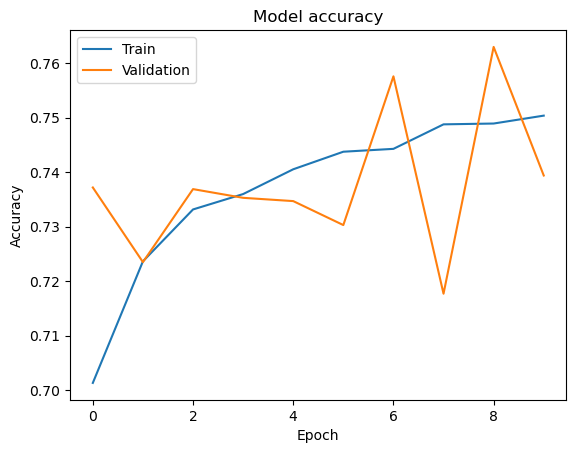

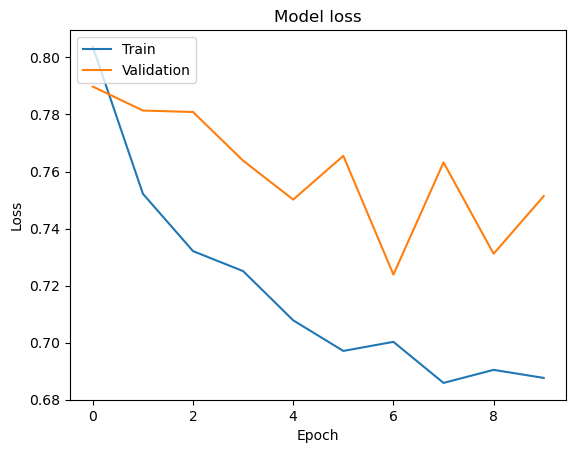

In [6]:
# Evaluate the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here I tried to fine-tune the model by unfreezing the last 20 layers of the base model, and retraining the model on the training set. I also used early stopping to prevent overfitting.

In [ ]:
# Optimize the model (fine-tuning, dropout, and early stopping)
for layer in base_model.layers[-20:]:
    layer.trainable = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 2)
#define check point
# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_weights.h5', save_weights_only=True, save_best_only=True)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetuned = model.fit(train_generator,
                              epochs=2,
                              validation_data=validation_generator,
                              callbacks=[early_stopping, checkpoint_callback])

1251/1251 [==============================] - 5768s 5s/step - loss: 0.3640 - accuracy: 0.8679 - val_loss: 0.6758 - val_accuracy: 0.7235

Once again computational issues prevented me from running the model for more epochs, but the results are still better than the previous model.

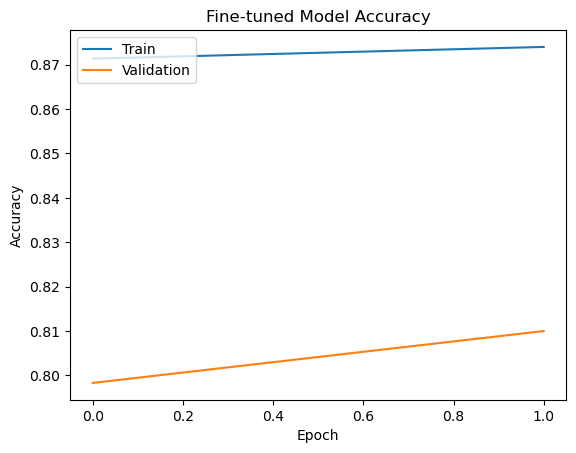

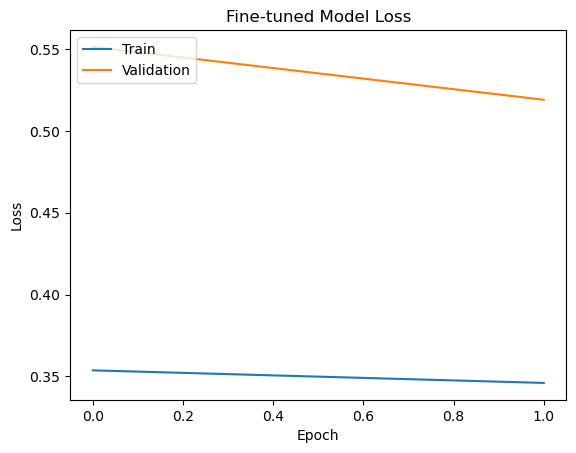

In [17]:
# Plot fine-tuned model accuracy
plt.plot(history_finetuned.history['accuracy'])
plt.plot(history_finetuned.history['val_accuracy'])
plt.title('Fine-tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot fine-tuned model loss
plt.plot(history_finetuned.history['loss'])
plt.plot(history_finetuned.history['val_loss'])
plt.title('Fine-tuned Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
# Save the model
model.save("shoe_recognition_model.h5")
